In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform
import joblib


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("../data/data_v2/data_conso.csv")

In [3]:
data.columns = ['VITESSE_SURFACE_LOCH', 'CONSOMMATION_MP', 'CHALUT', 'ETAT_MER']

In [4]:
data.head()

,VITESSE_SURFACE_LOCH,CONSOMMATION_MP,CHALUT,ETAT_MER
0,3.87,64.563018,0,0.4042
1,3.96,66.056309,0,0.4096
2,4.04,67.637070,0,0.4096
3,4.13,69.296786,0,0.4663
4,4.20,71.022610,0,0.5095


In [5]:
data['VITESSE_SURFACE_LOCH_2'] = data['VITESSE_SURFACE_LOCH'].apply(lambda x : x**2)
data['VITESSE_SURFACE_LOCH_3'] = data['VITESSE_SURFACE_LOCH'].apply(lambda x : x**3)

<Axes: xlabel='VITESSE_SURFACE_LOCH_2', ylabel='CONSOMMATION_MP'>

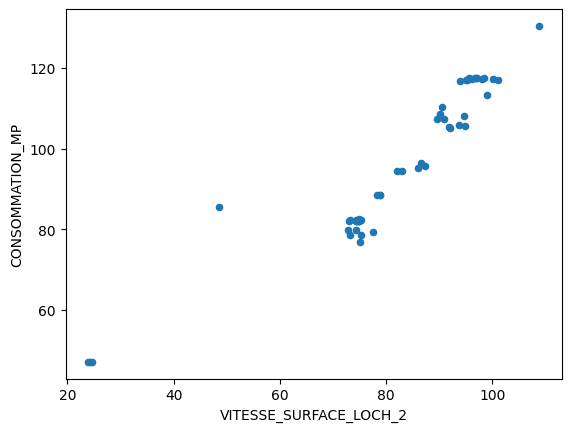

In [6]:
data.query("CHALUT == 0").query("ETAT_MER <0.35").plot.scatter(x='VITESSE_SURFACE_LOCH_2', y='CONSOMMATION_MP')

In [7]:
target = "CONSOMMATION_MP"
X = data.drop(columns=[target])
y = data[target]
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
preprocessing_pipeline = Pipeline(steps=[
    ("scaling", ColumnTransformer([
        ("num", num_transformer, [col for col in X.columns])
    ]))
])
model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessing_pipeline),
    ("regressor", XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
y_train_pred = model_pipeline.predict(X_train)

In [8]:
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
print("R2:", r2_score(y_train, y_train_pred))

MAE: 4.135976762662502
RMSE: 6.239710063383782
R2: 0.9109637663489065


In [9]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

MAE: 4.191080280301068
RMSE: 6.429771728169642
R2: 0.9056000921350027


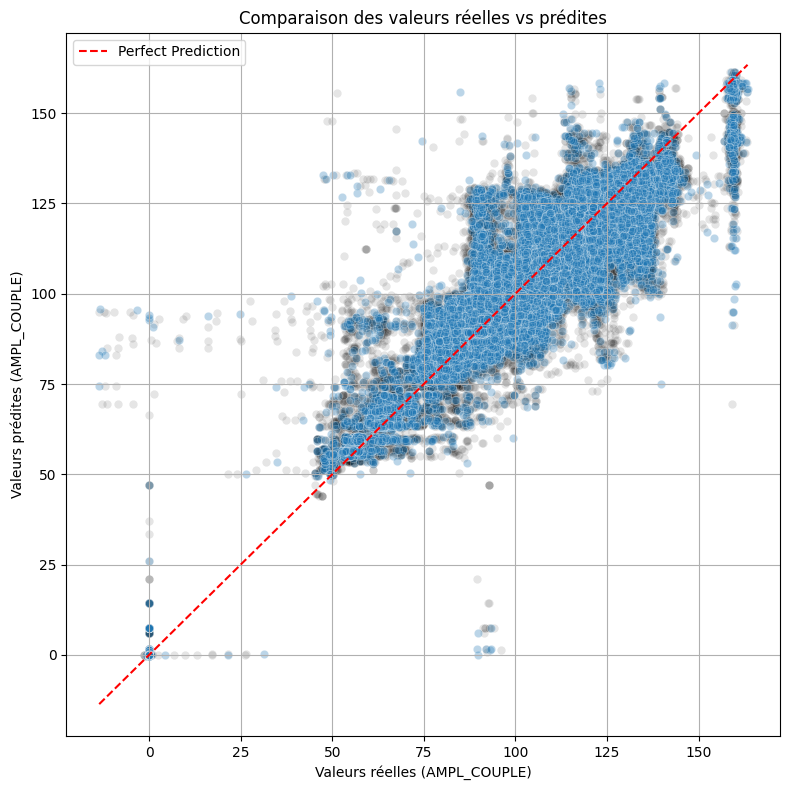

In [10]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.1, c='k')
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Valeurs réelles (AMPL_COUPLE)")
plt.ylabel("Valeurs prédites (AMPL_COUPLE)")
plt.title("Comparaison des valeurs réelles vs prédites")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Hyper Params Optimization

In [67]:
N_ITER = 100

In [68]:
%%time
xgb_param_dist = {
    "regressor__n_estimators": randint(100, 300),
    "regressor__max_depth": randint(3, 15),
    "regressor__learning_rate": uniform(0.01, 0.3),
    "regressor__subsample": uniform(0.6, 0.4),
    "regressor__colsample_bytree": uniform(0.6, 0.4),
    "regressor__gamma": uniform(0, 5),
    "regressor__reg_alpha": uniform(0, 1),
    "regressor__reg_lambda": uniform(0, 1)
}

xgb_random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=N_ITER,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 6.09 s, sys: 2.85 s, total: 8.94 s
Wall time: 4min 37s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('scaling',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                ['VITESSE_SURFACE_LOCH',
                                                                                                 'CHALUT',
                                                                                                 'ETAT_MER',
                                                                                                 'VITESSE_SURFACE_LOCH_2',
                                                                                                 'VITESSE_SURFACE_LOCH_3'])]))])),
                                             ('regressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None...
                                        'regressor__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31a466f90>,
                                        'regressor__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31a465a50>,
                                        'regressor__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x31a3e7b10>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [69]:
y_pred = xgb_random_search.predict(X_test)
y_train_pred = xgb_random_search.predict(X_train)

In [70]:
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
print("R2:", r2_score(y_train, y_train_pred))

MAE: 4.141135102789856
RMSE: 6.250746212103376
R2: 0.9106485318007054


In [71]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

MAE: 4.190456244697353
RMSE: 6.427593116627171
R2: 0.905664052690796


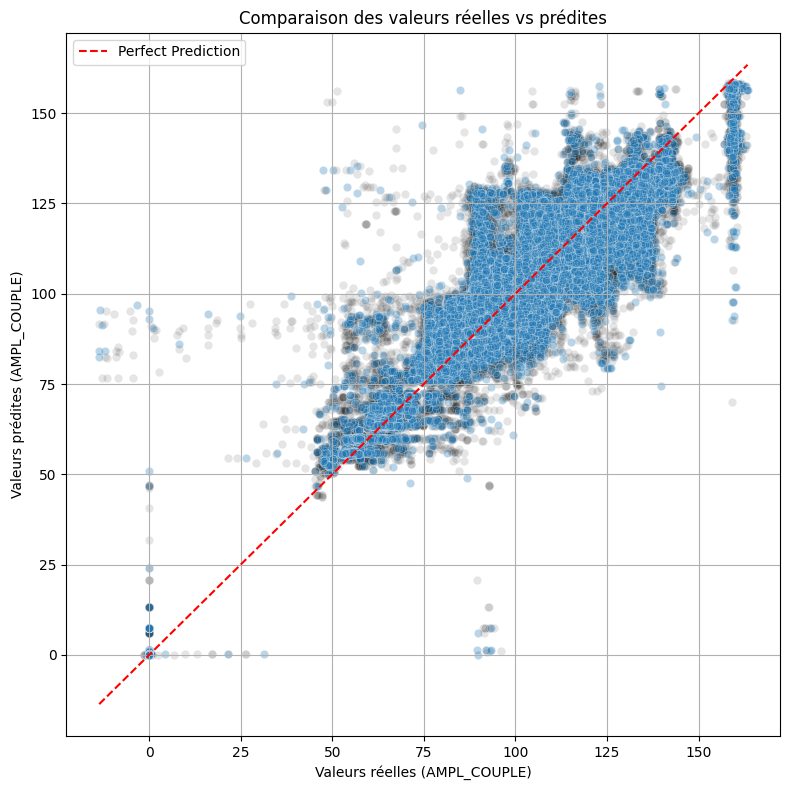

In [72]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.1, c='k')
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Valeurs réelles (AMPL_COUPLE)")
plt.ylabel("Valeurs prédites (AMPL_COUPLE)")
plt.title("Comparaison des valeurs réelles vs prédites")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Sauver le model

In [73]:
best_model = xgb_random_search.best_estimator_
joblib.dump(best_model, "xgb_pipeline_model_v2.pkl")

['xgb_pipeline_model_v2.pkl']

### Pour récuperer le model

In [74]:
loaded_model = joblib.load("xgb_pipeline_model_v2.pkl")
y_pred_loaded = loaded_model.predict(X_test)

# Feature importance

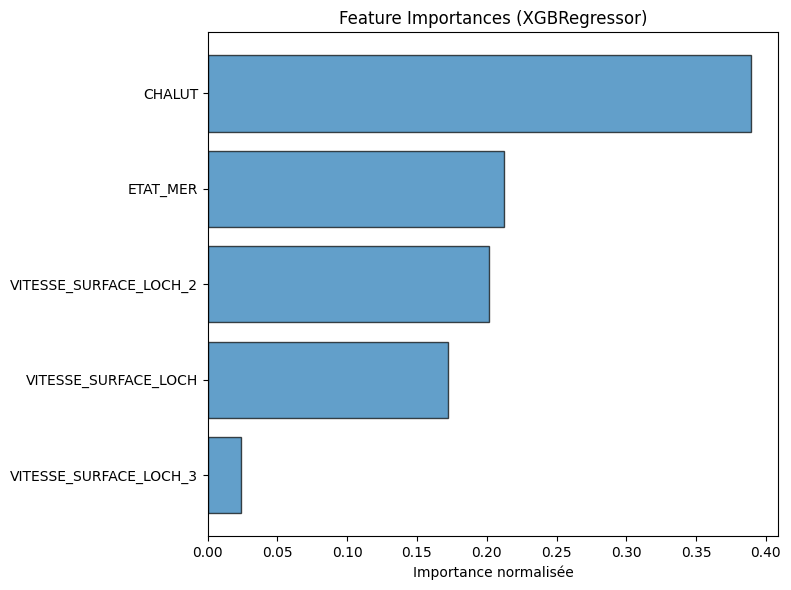

In [75]:
importances = best_model['regressor'].feature_importances_
names = X.columns.tolist()

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_names       = [names[i] for i in indices]

plt.figure(figsize=(8, 6))
plt.barh(sorted_names, sorted_importances, edgecolor='black', alpha=0.7)
plt.gca().invert_yaxis()
plt.xlabel("Importance normalisée")
plt.title("Feature Importances (XGBRegressor)")
plt.tight_layout()
plt.show()


# Pour prédire le delta couple

In [76]:
X_test_0 = X_test.copy()

In [77]:
X_test_0['CHALUT'] = 0
X_test_0['ETAT_MER'] = X_test['ETAT_MER'].min()
X_test_0

,VITESSE_SURFACE_LOCH,CHALUT,ETAT_MER,VITESSE_SURFACE_LOCH_2,VITESSE_SURFACE_LOCH_3
159175,4.800000,0,0.28,23.040000,110.592000
364624,9.360001,0,0.28,87.609619,820.026119
235625,2.650000,0,0.28,7.022500,18.609625
247555,3.790000,0,0.28,14.364100,54.439939
108448,9.280000,0,0.28,86.118400,799.178752
...,...,...,...,...,...
311990,9.610001,0,0.28,92.352119,887.503958
208172,2.910000,0,0.28,8.468100,24.642171
274819,9.260000,0,0.28,85.747600,794.022776
41850,9.120001,0,0.28,83.174418,758.550778


In [78]:
y_pred_at_0_load = best_model.predict(X_test_0)
y_pred_with_load = best_model.predict(X_test)

In [79]:
delta_conso = y_pred_with_load-y_pred_at_0_load

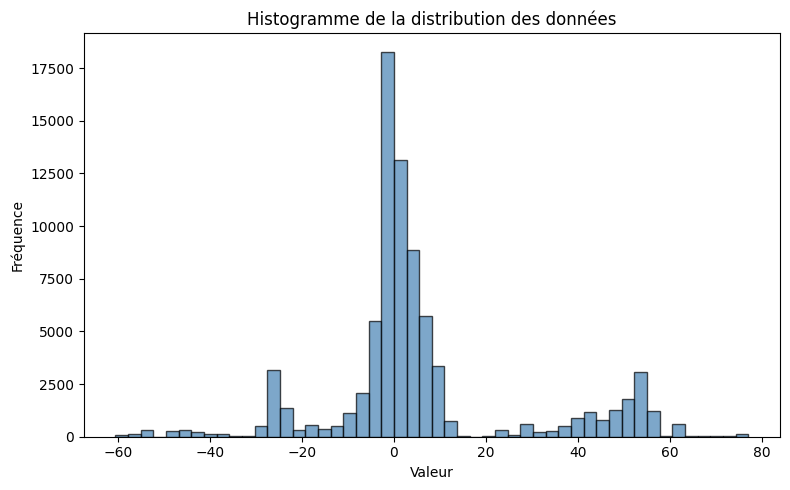

In [80]:
# Création de l'histogramme
plt.figure(figsize=(8, 5))           # taille de la figure (optionnel)
plt.hist(delta_conso, bins=50,              # nombre de barres
         color='steelblue',          # couleur des barres
         edgecolor='black',          # couleur des bordures
         alpha=0.7)                  # transparence

# Légendes et titre
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.title('Histogramme de la distribution des données')

# Affichage
plt.tight_layout()
plt.show()

# Monotonic Constraints

In [13]:
X.columns

Index(['VITESSE_SURFACE_LOCH', 'CHALUT', 'ETAT_MER', 'VITESSE_SURFACE_LOCH_2',
       'VITESSE_SURFACE_LOCH_3'],
      dtype='object')

In [17]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

target = "CONSOMMATION_MP"
X = data.drop(columns=[target])
y = data[target]

feature_names = [
    "VITESSE_SURFACE_LOCH",
    "CHALUT",
    "ETAT_MER",
    "VITESSE_SURFACE_LOCH_2",
    "VITESSE_SURFACE_LOCH_3"
]

monotonic_constraints = tuple([1] * len(feature_names))

preprocessor = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), feature_names)
])

model_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        monotone_constraints=monotonic_constraints
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['VITESSE_SURFACE_LOCH',
                                                   'CHALUT', 'ETAT_MER',
                                                   'VITESSE_SURFACE_LOCH_2',
                                                   'VITESSE_SURFACE_LOCH_3'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=N...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=(1, 1, 1, 1, 1),
                              multi_strategy=None, n_estimators=100, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [19]:
y_pred = model_pipeline.predict(X_test)
y_train_pred = model_pipeline.predict(X_train)

In [20]:
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
print("R2:", r2_score(y_train, y_train_pred))

MAE: 5.284697052291309
RMSE: 7.8898537432387466
R2: 0.8576439707738377


In [21]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

MAE: 5.239914446764454
RMSE: 7.8377215244630625
R2: 0.8597315110102342


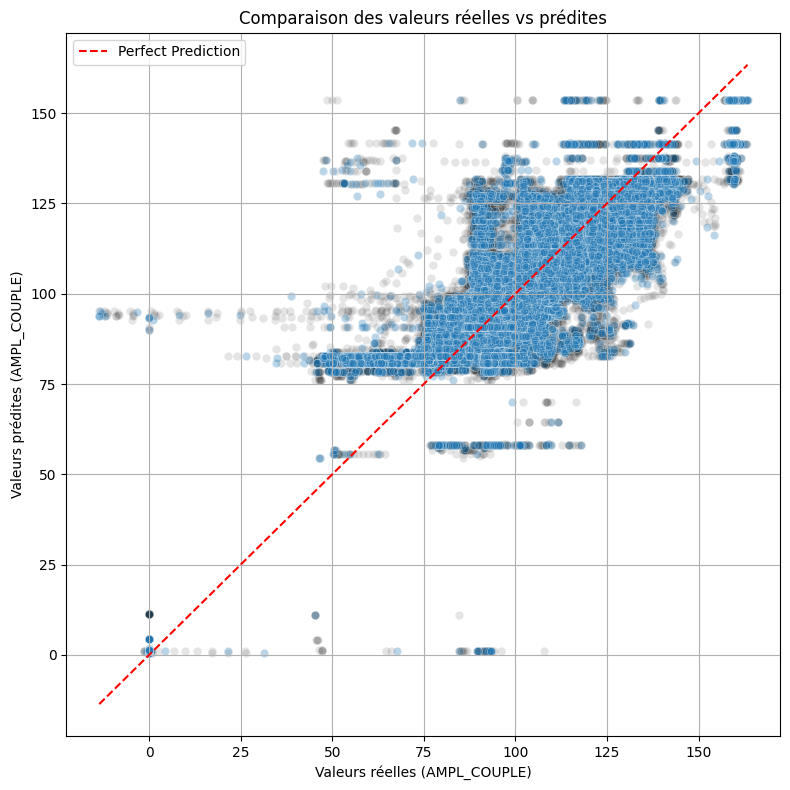

In [22]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.1, c='k')
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Valeurs réelles (AMPL_COUPLE)")
plt.ylabel("Valeurs prédites (AMPL_COUPLE)")
plt.title("Comparaison des valeurs réelles vs prédites")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


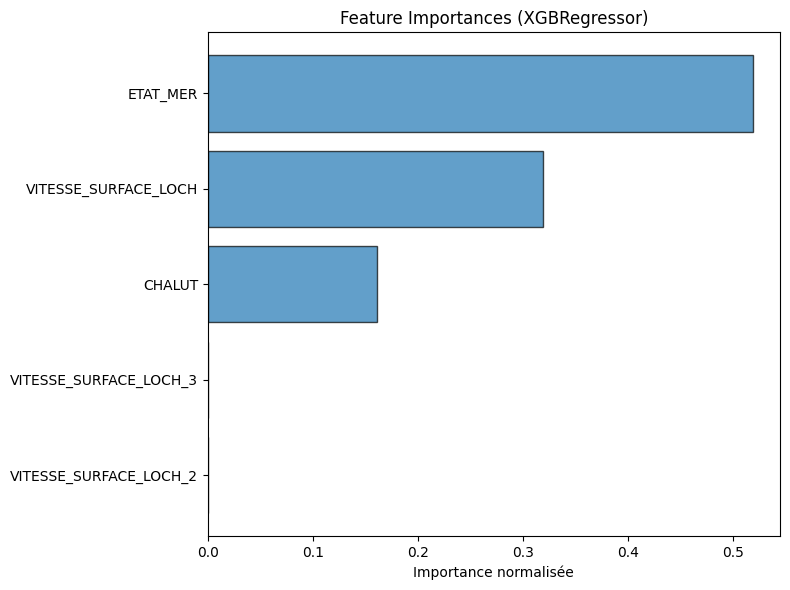

In [26]:
importances = model_pipeline['regressor'].feature_importances_
names = X.columns.tolist()

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_names       = [names[i] for i in indices]

plt.figure(figsize=(8, 6))
plt.barh(sorted_names, sorted_importances, edgecolor='black', alpha=0.7)
plt.gca().invert_yaxis()
plt.xlabel("Importance normalisée")
plt.title("Feature Importances (XGBRegressor)")
plt.tight_layout()
plt.show()


# Pour prédire le delta couple

In [27]:
X_test_0 = X_test.copy()

In [28]:
X_test_0['CHALUT'] = 0
X_test_0['ETAT_MER'] = X_test['ETAT_MER'].min()
X_test_0

,VITESSE_SURFACE_LOCH,CHALUT,ETAT_MER,VITESSE_SURFACE_LOCH_2,VITESSE_SURFACE_LOCH_3
159175,4.800000,0,0.28,23.040000,110.592000
364624,9.360001,0,0.28,87.609619,820.026119
235625,2.650000,0,0.28,7.022500,18.609625
247555,3.790000,0,0.28,14.364100,54.439939
108448,9.280000,0,0.28,86.118400,799.178752
...,...,...,...,...,...
311990,9.610001,0,0.28,92.352119,887.503958
208172,2.910000,0,0.28,8.468100,24.642171
274819,9.260000,0,0.28,85.747600,794.022776
41850,9.120001,0,0.28,83.174418,758.550778


In [29]:
y_pred_at_0_load = model_pipeline.predict(X_test_0)
y_pred_with_load = model_pipeline.predict(X_test)

In [30]:
delta_conso = y_pred_with_load-y_pred_at_0_load

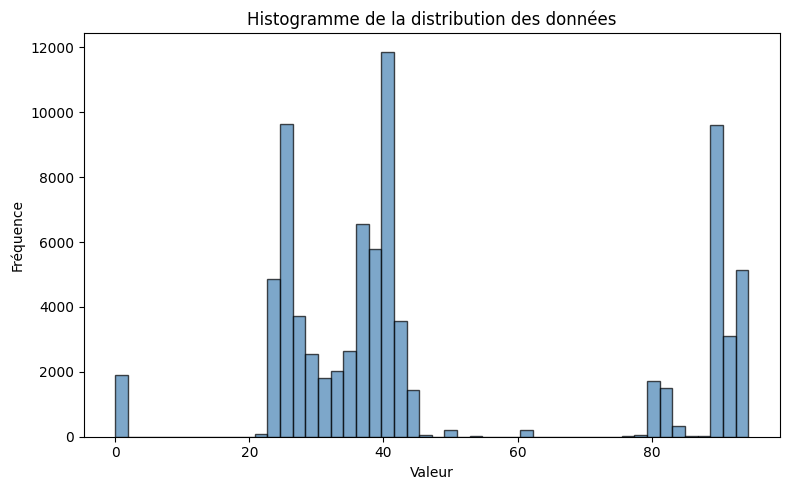

In [31]:
# Création de l'histogramme
plt.figure(figsize=(8, 5))           # taille de la figure (optionnel)
plt.hist(delta_conso, bins=50,              # nombre de barres
         color='steelblue',          # couleur des barres
         edgecolor='black',          # couleur des bordures
         alpha=0.7)                  # transparence

# Légendes et titre
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.title('Histogramme de la distribution des données')

# Affichage
plt.tight_layout()
plt.show()

In [38]:
N_ITER = 100

In [39]:
target = "CONSOMMATION_MP"
X = data.drop(columns=[target])
y = data[target]

feature_names = [
    "VITESSE_SURFACE_LOCH",
    "CHALUT",
    "ETAT_MER",
    "VITESSE_SURFACE_LOCH_2",
    "VITESSE_SURFACE_LOCH_3"
]

monotonic_constraints = tuple([1] * len(feature_names))

preprocessor = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), feature_names)
])

model_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        monotone_constraints=monotonic_constraints
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_param_dist = {
    "regressor__n_estimators": randint(100, 300),
    "regressor__max_depth":      randint(3, 15),
    "regressor__learning_rate":  uniform(0.01, 0.3),
    "regressor__subsample":      uniform(0.6, 0.4),
    "regressor__colsample_bytree": uniform(0.6, 0.4),
    "regressor__gamma":          uniform(0, 5),
    "regressor__reg_alpha":      uniform(0, 1),
    "regressor__reg_lambda":     uniform(0, 1)
}

xgb_random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=N_ITER,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['VITESSE_SURFACE_LOCH',
                                                                                'CHALUT',
                                                                                'ETAT_MER',
                                                                                'VITESSE_SURFACE_LOCH_2',
                                                                                'VITESSE_SURFACE_LOCH_3'])])),
                                             ('regressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsam...
                                        'regressor__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x309cf1cd0>,
                                        'regressor__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x309cf20d0>,
                                        'regressor__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x309cf2450>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [45]:
xgb_random_search.best_params_

{'regressor__colsample_bytree': 0.9314950036607718,
 'regressor__gamma': 1.7837666334679465,
 'regressor__learning_rate': 0.09428035290621423,
 'regressor__max_depth': 14,
 'regressor__n_estimators': 140,
 'regressor__reg_alpha': 0.2962735057040824,
 'regressor__reg_lambda': 0.1652669390630025,
 'regressor__subsample': 0.6062545626964776}

In [40]:
y_pred = xgb_random_search.predict(X_test)
y_train_pred = xgb_random_search.predict(X_train)

In [41]:
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))
print("R2:", r2_score(y_train, y_train_pred))

MAE: 5.319005574488561
RMSE: 7.97048116690544
R2: 0.8547195955427538


In [42]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

MAE: 5.2708100468906
RMSE: 7.905383650226214
R2: 0.8572992146168468


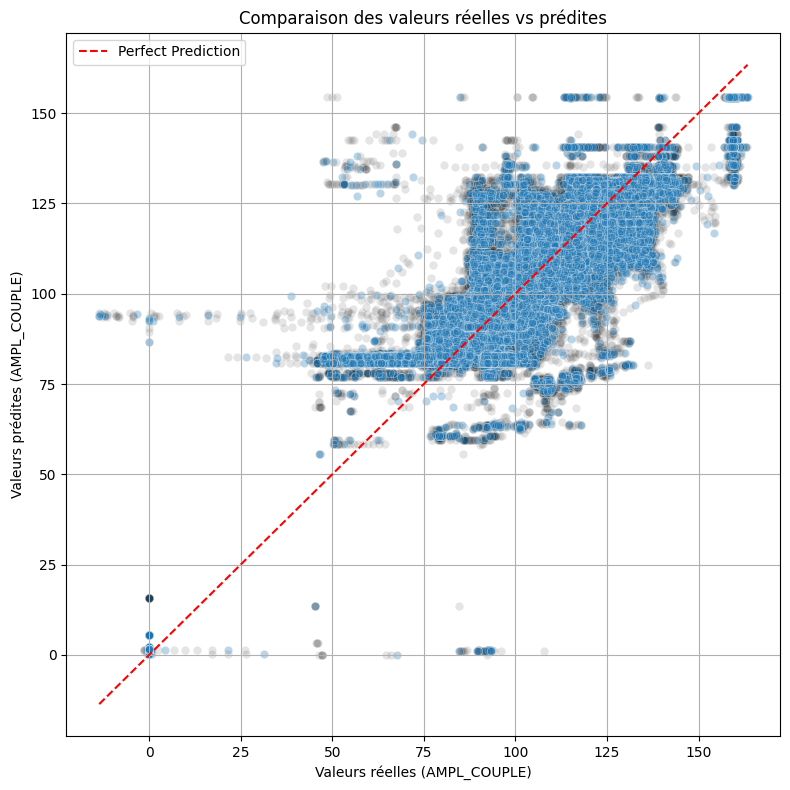

In [43]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.1, c='k')
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Valeurs réelles (AMPL_COUPLE)")
plt.ylabel("Valeurs prédites (AMPL_COUPLE)")
plt.title("Comparaison des valeurs réelles vs prédites")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()